# Iterations

решение уравнений методом последовательных итераций.

Постановка задачи:
Известно решение для некоторой эпохи, сделан расчет содержания водорода на новую эпоху,
надо найти решение для новой эпохи, в предположении что решение изменилось не сильно.

In [1]:
import math
from math import pi
import numpy as np
import pandas as pd

%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
import NotebookLoader
import Physics as ph
import SSM18 as s

importing Jupyter notebook from Physics.ipynb
Physics version 1.16 22.07.2020
importing Jupyter notebook from SSM18.ipynb
SSM18 version 1.10 22.07.2020


In [3]:
Z = s.Z

In [4]:
def load_model(epoch):
#     filename = 'Mass/4epoch%.02d.csv' % epoch
    filename = 'FromCenter/4epoch%.02d.csv' % epoch
    return pd.read_csv(filename)

In [45]:
# Загружаем известное решение (M-model)
epoch = 0
df = load_model(epoch)
dimM = len(df.index)
df

,Unnamed: 0,Mass,Radius,Temperature,Density,Luminosity,Hydrogen,Opacity,Convection,Pressure,Velocity
0,0,0.000000e+00,0.000000e+00,1.451000e+07,90.088552,0.000000e+00,0.732,1.445585,0.0,1.794413e+17,1.208950e-10
1,1,7.513729e+23,1.258054e+07,1.451000e+07,90.088462,1.298535e+25,0.732,1.445584,0.0,1.794411e+17,1.208948e-10
2,2,6.010983e+24,2.516108e+07,1.450999e+07,90.088353,1.038826e+26,0.732,1.445586,0.0,1.794407e+17,1.208942e-10
3,3,2.028704e+25,3.774162e+07,1.450997e+07,90.088137,3.506012e+26,0.732,1.445589,0.0,1.794400e+17,1.208929e-10
4,4,4.808770e+25,5.032217e+07,1.450993e+07,90.087811,8.310454e+26,0.732,1.445594,0.0,1.794389e+17,1.208910e-10
...,...,...,...,...,...,...,...,...,...,...,...
9912,9912,1.991121e+33,4.739400e+10,6.892412e+03,0.000088,3.565993e+33,0.732,0.401054,1.0,8.357322e+07,1.617101e-47
9913,9913,1.991121e+33,4.739403e+10,6.887369e+03,0.000088,3.565993e+33,0.732,0.401053,1.0,8.342037e+07,1.602843e-47
9914,9914,1.991121e+33,4.739406e+10,6.882327e+03,0.000088,3.565993e+33,0.732,0.401052,1.0,8.326769e+07,1.588700e-47
9915,9915,1.991121e+33,4.739409e+10,6.877285e+03,0.000088,3.565993e+33,0.732,0.401051,1.0,8.311518e+07,1.574673e-47


In [46]:
m = df.Mass.values
r = df.Radius.values
t = df.Temperature.values
d = df.Density.values
l = df.Luminosity.values
x = df.Hydrogen.values
k = df.Opacity.values
c = df.Convection.values
p = df.Pressure.values
v = df.Velocity.values

In [47]:
ea = np.zeros(dimM) # несоответствие градиента давления
eb = np.zeros(dimM) # несоответствие градиента температуры 

In [48]:
def Error(df, ea, eb):
    """
    Вычисляем интегральную ошибку решения.
    
    Ошибка складывается из ошибок выполнения условий гидростатики и энергобаланса в каждой точке сетки кроме первой 
    и последней.
    
    :param df pandas.dataFrame - M-model
    :return error
    """
    m = df.Mass.values
    r = df.Radius.values
    t = df.Temperature.values
    d = df.Density.values
    l = df.Luminosity.values
    x = df.Hydrogen.values
    k = df.Opacity.values
    p = df.Pressure.values
    dimM = len(df)
    for i in range(dimM - 1):   
        g = ph.G*m[i]/pow(r[i], 2) if i > 0 else 0.
        a = -g*d[i]
        da = (p[i+1] - p[i])/(r[i+1] - r[i]) 
        br = 3/16*k[i]*d[i]*l[i]/ph.sigma/pow(t[i], 3)/4/pi/pow(r[i], 2) if i > 0 else 0.
        bc = 0.4*ph.MU(x[i], 1 - Z - x[i], Z)/ph.kB*ph.m_prot*g
        b = -br if br < bc else -bc
        db = (t[i+1] - t[i])/(r[i+1] - r[i])
        ea[i] = (da - a)
        eb[i] = (db - b)
    ea[-1] = 0.
    eb[-1] = 0.
    ea *= s.R/s.P0
    eb *= s.R/s.T0
    sa = (ea*ea).mean()
    sb = (eb*eb).mean()
    return sa + sb

In [49]:
def Recalc(df):
    """
    Пересчитываем параметры d, p, l, k как результат изменений r, t, x. (m - не меняется)
    
    :param df pandas.dataFrame - M-model
    """
    m = df.Mass.values
    r = df.Radius.values
    t = df.Temperature.values
    d = df.Density.values
    l = df.Luminosity.values
    x = df.Hydrogen.values
    k = df.Opacity.values
    c = df.Convection.values
    p = df.Pressure.values
    v = df.Velocity.values
    dimM = len(df)
    l[0] = 0.
    for i in range(dimM-1):
        d[i] = (m[i+1] - m[i])/4*3/pi/(pow(r[i+1], 3) - pow(r[i], 3))
        l[i+1] = l[i] + (m[i+1] - m[i])*ph.Etot(d[i], t[i], x[i], 1 - Z - x[i], Z)
    d[-1] = 0.
    p = ph.Pressure(d, t, x, 1 - Z - x, Z)
    k = ph.Opacity(d, t, x, 1 - Z - x, Z)
    

In [84]:
def RecalcHydrogen(df, years):
    """
    Пересчитываем распределение водорода на years лет вперед
    
    :param df pandas.dataFrame - M-model
    """
    x = df.Hydrogen.values
    x0 = df.Hydrogen.values
    v = df.Velocity.values
    x = x0*np.exp(-v*years)
    df.Hydrogen
    print(df.Hydrogen)
    print(x)

In [69]:
df0 = df.copy()
etot = Error(df0, ea, eb)
print(etot)

Recalc(df)
etot = Error(df, ea, eb)
print(etot)

3.9327777793907713e-07
3.9327777793907713e-07


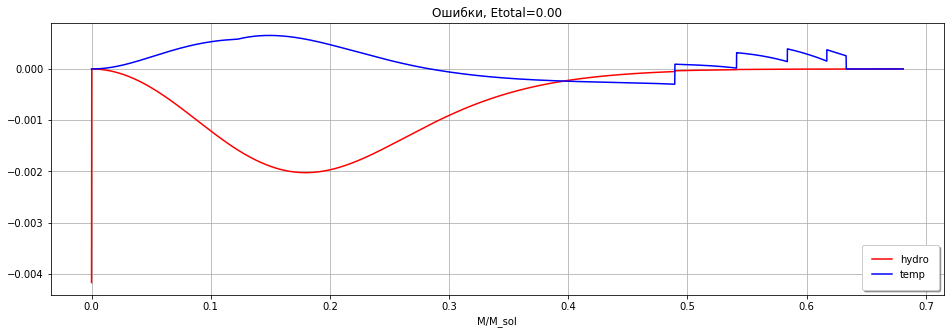

In [70]:
plt.figure(figsize=(16, 5))
ax = plt.axes()
m1 = m/s.M
r1 = r/s.R
plt.plot(r1, ea, color='red', label='hydro')
plt.plot(r1, eb, color='blue', label='temp')
# plt.plot(m1[1:-1], c[1:-1]*.001, ':k', marker='.', label='conv')
# plt.xlim(0.,0.01)
# plt.xlim(0.95,1.0)
# # plt.ylim(-0.01, 0.01)
plt.xlabel('M/M_sol')
plt.ylabel('')
plt.title('Ошибки, Etotal=%.2f' % etot)
ax.grid(b=True, which='both')
ax.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1);

In [74]:
df = df0.copy()

In [87]:
NG = 60 
err = np.zeros(NG + 1)
RecalcHydrogen(df, 1e8)
# print(df.Hydrogen)
Recalc(df)
# Теперь в df - начальное приближение для новой эпохи.

0       0.732
1       0.732
2       0.732
3       0.732
4       0.732
        ...  
9912    0.732
9913    0.732
9914    0.732
9915    0.732
9916    0.732
Name: Hydrogen, Length: 9917, dtype: float64
[0.72320377 0.72320378 0.72320382 ... 0.732      0.732      0.732     ]


In [73]:
count = 0
etot = Error(df, ea, eb)
err[count] = etot
etot

3.9327777793907713e-07

In [77]:
df.Velocity.values

array([1.20894970e-10, 1.20894849e-10, 1.20894206e-10, ...,
       1.58870045e-47, 1.57467256e-47, 1.56075839e-47])

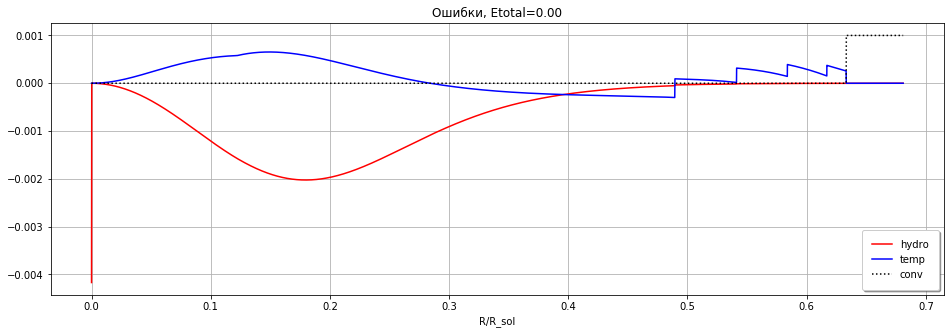

In [65]:
plt.figure(figsize=(16, 5))
ax = plt.axes()
m1 = m/s.M
r1 = r/s.R
plt.plot(r1, ea, color='red', label='hydro')
plt.plot(r1, eb, color='blue', label='temp')
plt.plot(r1, c*.001, ':k', label='conv')
# plt.xlim(0.,0.000001)
# plt.xlim(0.95,1.0)
# # plt.ylim(-0.01, 0.01)
plt.xlabel('R/R_sol')
plt.ylabel('')
plt.title('Ошибки, Etotal=%.2f' % etot)
ax.grid(b=True, which='both')
ax.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1);

In [118]:
%%time
"""
Цикл итераций. NG - число итераций, count - переменная цикла.
"""

count = 0
err[count] = Error(df, ea, eb)
print('count=%d Error=%.3e' % (count, err[count]))
k0 = 0.0001

while count < 5: #NG:
    # Варьируем r & t в направлении уменьшения ошибки, получая следующую итерацию.
    for i in range(dimM):
        r[i] = r[i]*(1 + k0*ea[i])
        t[i] = t[i]*(1 - k0*eb[i])
    # пересчитываем остальные переменные 
    Recalc(df)
    count += 1
    err[count] = Error(df, ea, eb)
    print('count=%d Error=%.3e Ratio=%.3f' % (count, err[count], 100*err[count-1]/err[count] - 100.))


count=0 Error=7.087e-05
count=1 Error=6.769e-05 Ratio=4.703
count=2 Error=2.570e-04 Ratio=-73.660
count=3 Error=1.857e+01 Ratio=-99.999
count=4 Error=4.161e+03 Ratio=-99.554
count=5 Error=1.838e+05 Ratio=-97.736
Wall time: 2.96 s


In [155]:
df1 = pd.DataFrame({'Mass': m, 'Radius': r, 'Temperature': t, 'Density': d, 
          'Luminosity': l, 'Hydrogen': x, 'Opacity': k, 'Convection': c, 'Pressure': p, 'Velocity': v})
df1

,Mass,Radius,Temperature,Density,Luminosity,Hydrogen,Opacity,Convection,Pressure,Velocity
0,0.000000e+00,0.000000e+00,1.451000e+07,90.073860,0.000000e+00,0.723205,1.445415,0.0,1.794120e+17,1.208753e-10
1,1.992041e+29,8.086197e+08,1.448616e+07,89.853305,3.327251e+30,0.723300,1.448873,0.0,1.786787e+17,1.195617e-10
2,3.984082e+29,1.019092e+09,1.447218e+07,89.722614,6.633677e+30,0.723355,1.450894,0.0,1.782465e+17,1.187975e-10
3,5.976123e+29,1.166858e+09,1.446045e+07,89.612835,9.922761e+30,0.723402,1.452590,0.0,1.778842e+17,1.181611e-10
4,7.968163e+29,1.284576e+09,1.444999e+07,89.514752,1.319646e+31,0.723442,1.454104,0.0,1.775610e+17,1.175968e-10
...,...,...,...,...,...,...,...,...,...,...
9996,1.991244e+33,4.536990e+10,3.854278e+05,0.035663,3.526911e+33,0.732000,0.825068,1.0,1.886897e+12,2.183289e-26
9997,1.991443e+33,4.560445e+10,3.415529e+05,0.029744,3.526911e+33,0.732000,0.754712,1.0,1.394588e+12,5.057721e-27
9998,1.991642e+33,4.589195e+10,2.883817e+05,0.023070,3.526911e+33,0.732000,0.675243,1.0,9.132617e+11,6.525222e-28
9999,1.991842e+33,4.628649e+10,2.164797e+05,0.014997,3.526911e+33,0.732000,0.578994,1.0,4.456675e+11,2.029214e-29


In [156]:
epoch = 1
_ = df1.to_csv(line_terminator='\n')
filename = "Mass/4epoch%.02d.csv" % epoch
print(filename)
csv_file = open(filename, "wt")
n = csv_file.write(_)
csv_file.close()

Mass/4epoch01.csv


In [147]:
epoch = 0
df = load_model(epoch)
d = df['Density'].values
t = df['Temperature'].values
d

array([9.00738577e+01, 8.90411272e+01, 8.84305086e+01, ...,
       1.25189351e-01, 7.53021785e-02, 2.09797553e-05])

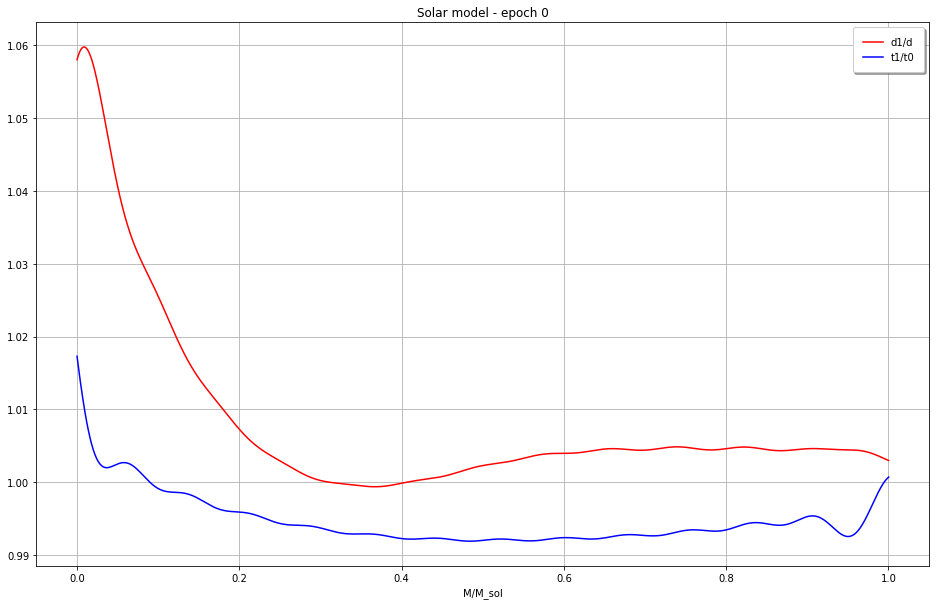

In [148]:
m1 = m/s.M
plt.figure(figsize=(16, 10))
ax = plt.axes()
# plt.plot(r1, c, color='black', label='Convection')
plt.plot(m1, d1/d, color='red', label='d1/d')
plt.plot(m1, t1/t, color='blue', label='t1/t0')
# plt.xlim(-0.1,0.1)
# plt.ylim(-0.1, 0.1)
plt.xlabel('M/M_sol')
plt.ylabel('')
plt.title('Solar model - epoch %d' % epoch)
ax.grid(b=True, which='both')
ax.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1);

In [149]:
ea = np.zeros(dimM)
eb = np.zeros(dimM)
for i in range(1, dimM-1):
    ea[i] = 3*pow((da[i] - a[i])/6760886, 2)
    eb[i] = pow((db[i] - b[i])/0.000324, 2)
sa = ea.sum()
sb = eb.sum()
etot = (sa + sb)/0.09726621893099568

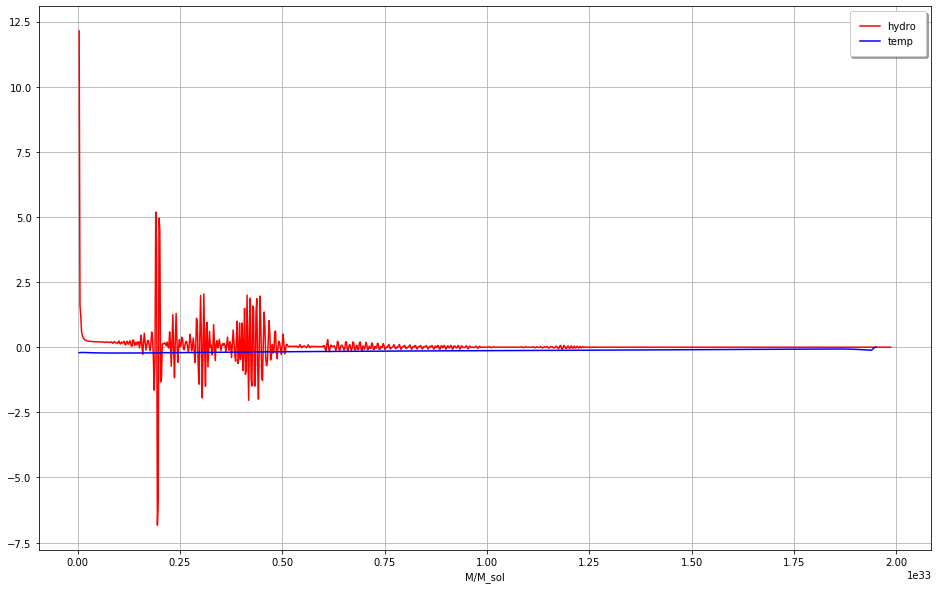

In [37]:
plt.figure(figsize=(16, 10))
ax = plt.axes()
# plt.plot(r1, c, color='black', label='Convection')
plt.plot(m[2:-2], ea[2:-2], color='red', label='hydro')
plt.plot(m[2:-20], eb[2:-20], color='blue', label='temp')
# plt.xlim(-0.1,0.1)
# plt.ylim(-0.1, 0.1)
plt.xlabel('M/M_sol')
plt.ylabel('')
# plt.title('Error %.2f' % etot)
ax.grid(b=True, which='both')
ax.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1);

$ a = \mu ^ 2$